In [119]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [120]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [121]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [122]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [123]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [124]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [125]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [105]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date = recent_date.split("-")
recent_date


<class 'list'>


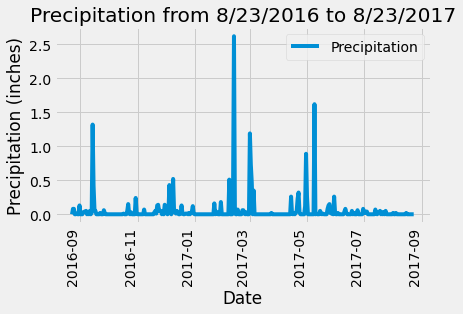

In [108]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
 
# Calculate the date one year from the last date in data set.
date_calc = dt.date(int(recent_date[0]),int(recent_date[1]),int(recent_date[2]))-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores

prcp_date = session.query(Measurement.date,Measurement.prcp).\
                filter(Measurement.date >= date_calc).\
                group_by(Measurement.date).\
                order_by(Measurement.date.desc()).all()



# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_date, columns=["Date", "Precipitation"])
df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)
df.head(10)

# Sort the dataframe by date
date_df = df.sort_values("Date")
date_df.head(10)


# Use Pandas Plotting with Matplotlib to plot the data
date_df.plot.line()
plt.title('Precipitation from 8/23/2016 to 8/23/2017')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation = 90)
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.describe()

,Precipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
st_id = session.query(Station.id).all()
st_count = len(st_id)
st_count

9

In [70]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
m_stations = session.query(Measurement.station).all()
sta = []
for x in range(len(m_stations)):
    sta.append(m_stations[x][0])
active_stations = pd.Series(sta).value_counts()
df = pd.DataFrame(active_stations,columns=['Frequency'])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index':'Station'},inplace=True)
most_active_station = df.loc[df['Frequency']==df['Frequency'].max()]['Station'][0]
print(df)
print("")
print(f"Most active station: {most_active_station}")


       Station  Frequency
0  USC00519281       2772
1  USC00519397       2724
2  USC00513117       2709
3  USC00519523       2669
4  USC00516128       2612
5  USC00514830       2202
6  USC00511918       1979
7  USC00517948       1372
8  USC00518838        511

Most active station: USC00519281


In [77]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs) ]
temp_query = session.query(*sel).\
    filter(Measurement.station == most_active_station)

print(f"For most active station ({most_active_station}):")
print("")
print(f"Lowest Temperature (F): {temp_query[0][0]}")
print(f"Highest Temperature (F): {temp_query[0][1]}")
print(f"Average Temperature (F): {round(temp_query[0][2],1)}")

For most active station (USC00519281):

Lowest Temperature (F): 54.0
Highest Temperature (F): 85.0
Average Temperature (F): 71.7


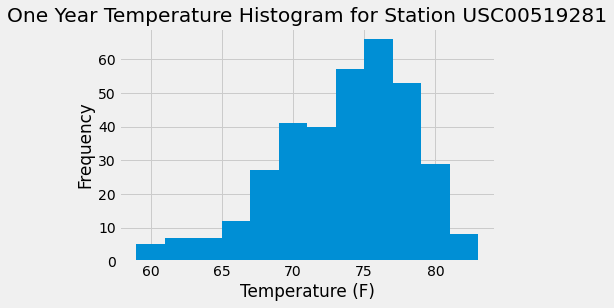

In [117]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obsv = session.query(Measurement.tobs).\
    filter(Measurement.date >= date_calc).\
    filter(Measurement.station == most_active_station)

temps = []
for x in range(len(temp_obsv.all())):
    temps.append(temp_obsv.all()[x][0])
temps

temperatures = pd.Series(temps);
temperatures.plot.hist(bins=12);
plt.title(f"One Year Temperature Histogram for Station {most_active_station}");
plt.xlabel("Temperature (F)");

# Close session

In [118]:
# Close Session
session.close()